In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =6.375563e-24

nband = 80

ng =9

ng_adju = (/ 2 , 2 /) 

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 1000

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.65 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

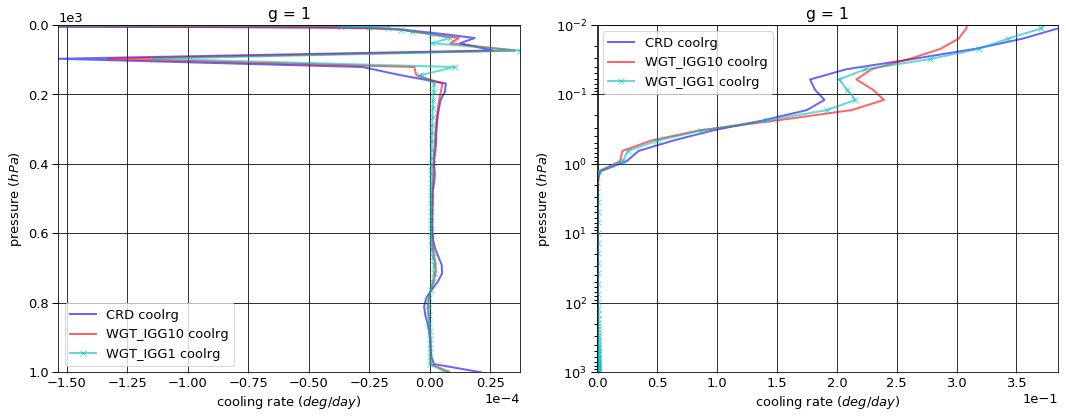

# Figure: cooling rate g-group 2

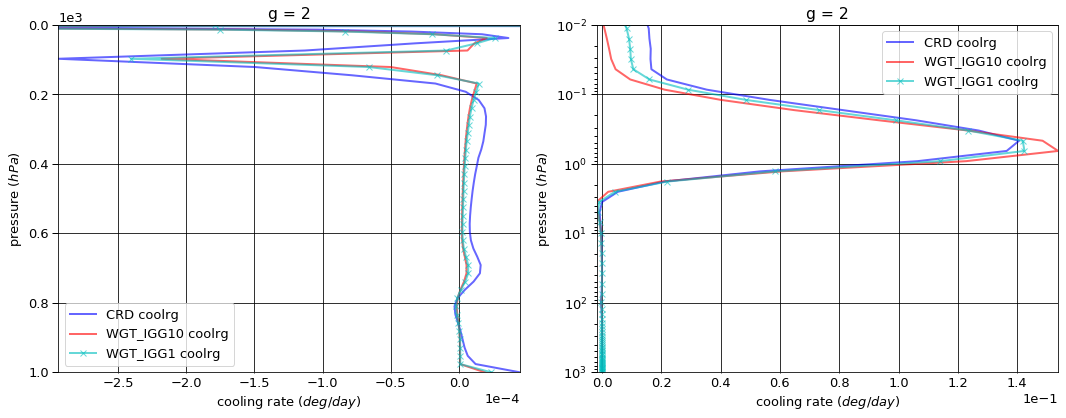

# Figure: cooling rate g-group 3

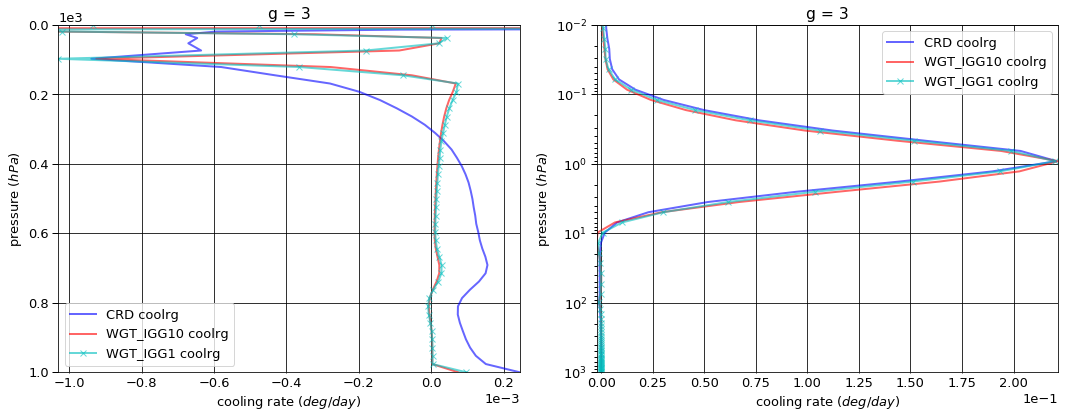

# Figure: cooling rate g-group 4

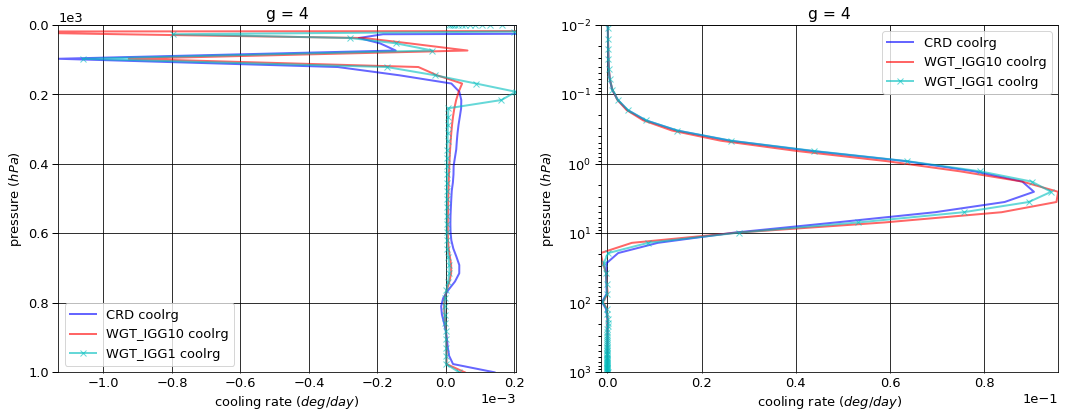

# Figure: cooling rate g-group 5

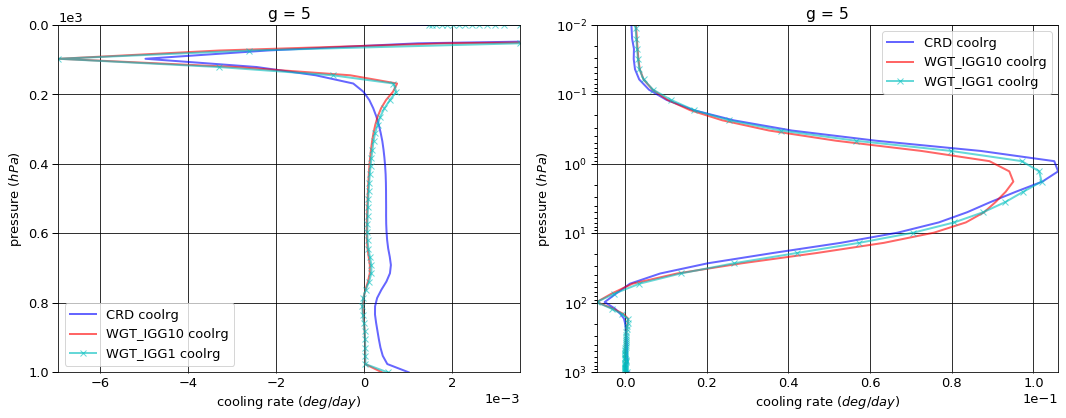

# Figure: cooling rate g-group 6

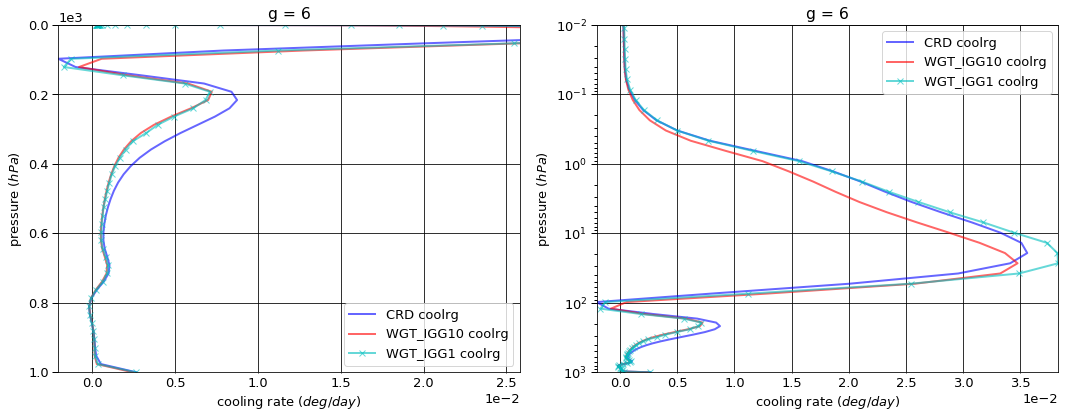

# Figure: cooling rate g-group 7

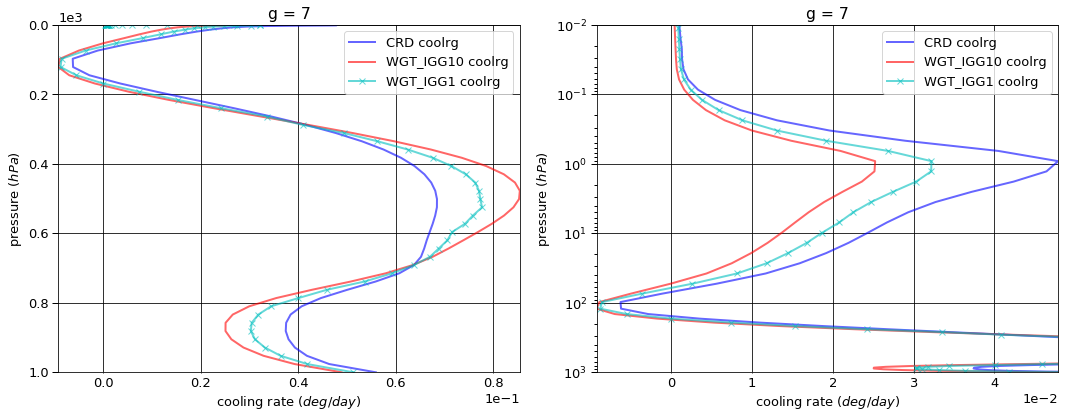

# Figure: cooling rate g-group 8

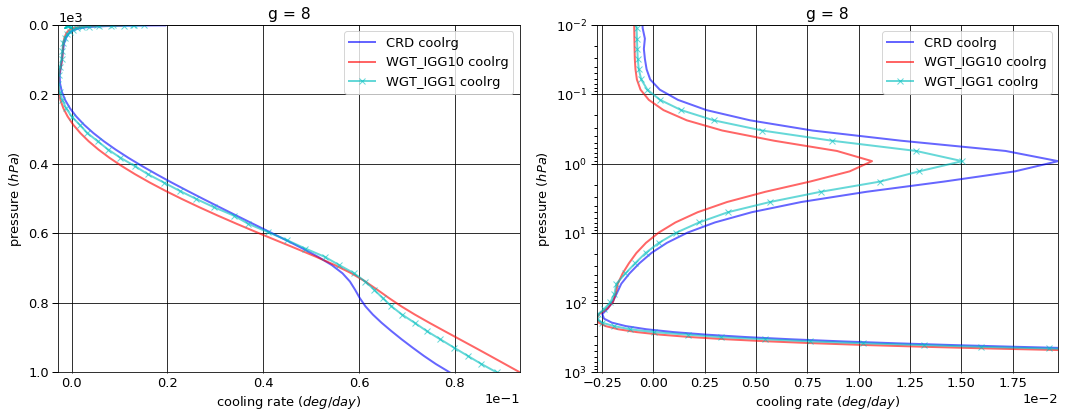

# Figure: cooling rate g-group 9

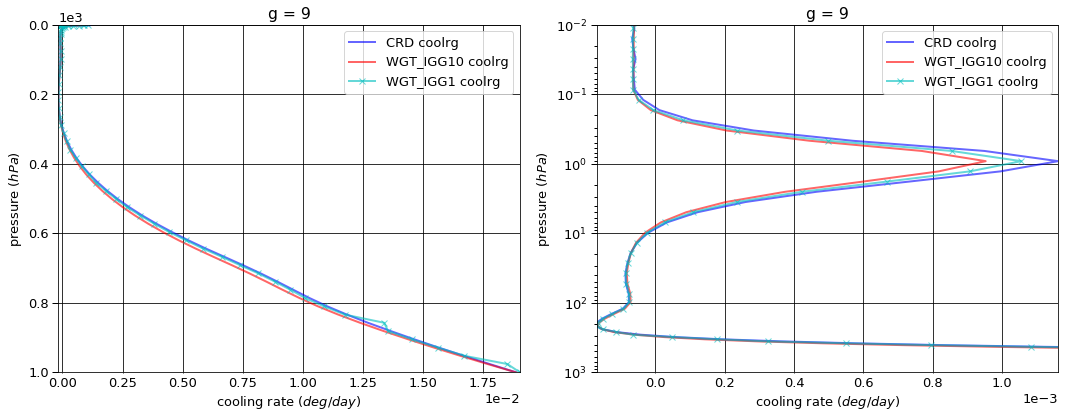

# Figure: cooling rate g-group total

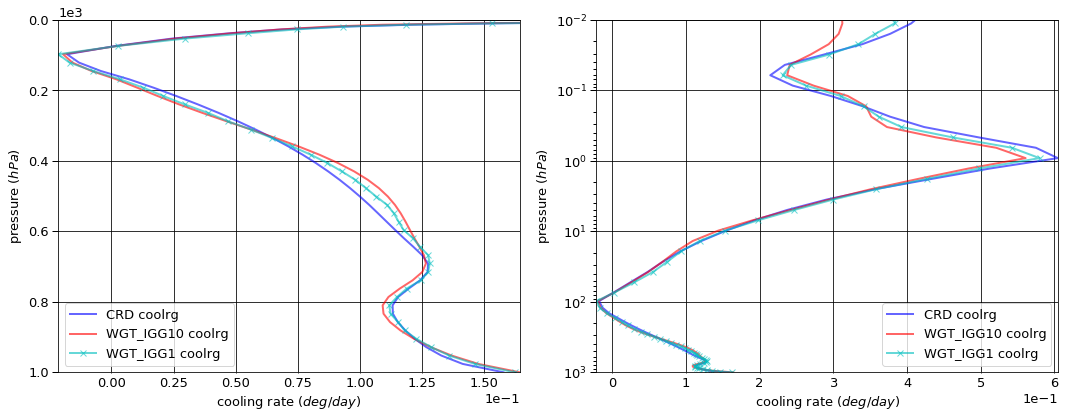

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.010256  0.000000  -0.010256
  1013.0   76     -0.025501  0.025437  -0.000064
2 0.0      1      -0.017422  0.000000  -0.017422
  1013.0   76     -0.029836  0.029654  -0.000182
3 0.0      1      -0.062126  0.000000  -0.062126
  1013.0   76     -0.106864  0.103944  -0.002920
4 0.0      1      -0.077534  0.000000  -0.077534
  1013.0   76     -0.153957  0.153475  -0.000482
5 0.0      1      -0.221628  0.000000  -0.221628
  1013.0   76     -0.532802  0.522122  -0.010680
6 0.0      1      -0.467276  0.000000  -0.467276
  1013.0   76     -1.513964  1.505146  -0.008819
7 0.0      1      -5.974823  0.000000  -5.974823
  1013.0   76    -10.535612  9.718835  -0.816777
8 0.0      1      -9.970910  0.000000  -9.970910
  1013.0   76    -11.384137  5.155220  -6.228917
9 0.0      1     -14.072455  0.000000 -14.072455
  1013.0   76    -14.209061  0.748448 -13.460613


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.009862   0.000000  -0.009862
  1013.0   76     -0.025501   0.025478  -0.000023
2 0.0      1      -0.017854   0.000000  -0.017854
  1013.0   76     -0.029836   0.029783  -0.000053
3 0.0      1      -0.064134   0.000000  -0.064134
  1013.0   76     -0.106864   0.106656  -0.000208
4 0.0      1      -0.079280   0.000000  -0.079280
  1013.0   76     -0.153957   0.153803  -0.000154
5 0.0      1      -0.212346   0.000000  -0.212346
  1013.0   76     -0.532802   0.531690  -0.001112
6 0.0      1      -0.425744   0.000000  -0.425744
  1013.0   76     -1.513964   1.506730  -0.007234
7 0.0      1      -5.656585   0.000000  -5.656585
  1013.0   76    -10.535612  10.054921  -0.480691
8 0.0      1     -10.086776   0.000000 -10.086776
  1013.0   76    -11.384137   5.201836  -6.182301
9 0.0      1     -14.082777   0.000000 -14.082777
  1013.0   76    -14.209061   0.715515 -13.493546


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009911  0.000000  -0.009911
  1013.0   76     -0.025501  0.025483  -0.000018
2 0.0      1      -0.017637  0.000000  -0.017637
  1013.0   76     -0.029836  0.029770  -0.000065
3 0.0      1      -0.063336  0.000000  -0.063336
  1013.0   76     -0.106864  0.106593  -0.000271
4 0.0      1      -0.078619  0.000000  -0.078619
  1013.0   76     -0.153957  0.153849  -0.000108
5 0.0      1      -0.210027  0.000000  -0.210027
  1013.0   76     -0.532802  0.531327  -0.001475
6 0.0      1      -0.436399  0.000000  -0.436399
  1013.0   76     -1.513964  1.506045  -0.007920
7 0.0      1      -5.710961  0.000000  -5.710961
  1013.0   76    -10.535612  9.962621  -0.572991
8 0.0      1      -9.981565  0.000000  -9.981565
  1013.0   76    -11.384137  5.331470  -6.052667
9 0.0      1     -14.076164  0.000000 -14.076164
  1013.0   76    -14.209061  0.743111 -13.465950


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.938251e-04  0.000000  0.000394
  1013.0   76     0.000000e+00  0.000041  0.000041
2 0.0      1     -4.324220e-04  0.000000 -0.000432
  1013.0   76     0.000000e+00  0.000129  0.000129
3 0.0      1     -2.007936e-03  0.000000 -0.002008
  1013.0   76     0.000000e+00  0.002713  0.002713
4 0.0      1     -1.746429e-03  0.000000 -0.001746
  1013.0   76     0.000000e+00  0.000328  0.000328
5 0.0      1      9.281710e-03  0.000000  0.009282
  1013.0   76     0.000000e+00  0.009568  0.009568
6 0.0      1      4.153217e-02  0.000000  0.041532
  1013.0   76    -2.220446e-16  0.001584  0.001584
7 0.0      1      3.182383e-01  0.000000  0.318238
  1013.0   76     0.000000e+00  0.336086  0.336086
8 0.0      1     -1.158664e-01  0.000000 -0.115866
  1013.0   76    -1.776357e-15  0.046616  0.046616
9 0.0      1     -1.032200e-02  0.000000 -0.010322
  1013.0   76     0.000000e+00 -0.032933 -0.032933


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.446534e-04  0.000000  0.000345
  1013.0   76     0.000000e+00  0.000046  0.000046
2 0.0      1     -2.150340e-04  0.000000 -0.000215
  1013.0   76     0.000000e+00  0.000116  0.000116
3 0.0      1     -1.210122e-03  0.000000 -0.001210
  1013.0   76     0.000000e+00  0.002649  0.002649
4 0.0      1     -1.085371e-03  0.000000 -0.001085
  1013.0   76     0.000000e+00  0.000373  0.000373
5 0.0      1      1.160123e-02  0.000000  0.011601
  1013.0   76     0.000000e+00  0.009205  0.009205
6 0.0      1      3.087668e-02  0.000000  0.030877
  1013.0   76    -2.220446e-16  0.000899  0.000899
7 0.0      1      2.638619e-01  0.000000  0.263862
  1013.0   76     0.000000e+00  0.243786  0.243786
8 0.0      1     -1.065500e-02  0.000000 -0.010655
  1013.0   76    -1.776357e-15  0.176250  0.176250
9 0.0      1     -3.709000e-03  0.000000 -0.003709
  1013.0   76     0.000000e+00 -0.005337 -0.005337

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.386791
  1001.112500 75     0.000021
2 0.000312    1      0.007814
  1001.112500 75     0.000045
3 0.000312    1     -0.001014
  1001.112500 75     0.000245
4 0.000312    1      0.000013
  1001.112500 75     0.000142
5 0.000312    1      0.000445
  1001.112500 75     0.001008
6 0.000312    1      0.000180
  1001.112500 75     0.002652
7 0.000312    1      0.000386
  1001.112500 75     0.055907
8 0.000312    1     -0.000743
  1001.112500 75     0.078906
9 0.000312    1     -0.000056
  1001.112500 75     0.018850


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.242652
  1001.112500 75     0.000008
2 0.000312    1     -0.006096
  1001.112500 75     0.000019
3 0.000312    1     -0.002559
  1001.112500 75     0.000075
4 0.000312    1      0.000029
  1001.112500 75     0.000055
5 0.000312    1      0.001668
  1001.112500 75     0.000401
6 0.000312    1      0.000203
  1001.112500 75     0.002443
7 0.000312    1      0.000104
  1001.112500 75     0.048875
8 0.000312    1     -0.000965
  1001.112500 75     0.093563
9 0.000312    1     -0.000056
  1001.112500 75     0.018844


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.338446
  1001.112500 75     0.000006
2 0.000312    1     -0.000179
  1001.112500 75     0.000024
3 0.000312    1     -0.002668
  1001.112500 75     0.000097
4 0.000312    1      0.000010
  1001.112500 75     0.000039
5 0.000312    1      0.001475
  1001.112500 75     0.000527
6 0.000312    1      0.000238
  1001.112500 75     0.002607
7 0.000312    1      0.000430
  1001.112500 75     0.051284
8 0.000312    1     -0.000913
  1001.112500 75     0.088710
9 0.000312    1     -0.000058
  1001.112500 75     0.019011


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.441389e-01
  1001.112500 75    -1.289774e-05
2 0.000312    1     -1.391016e-02
  1001.112500 75    -2.561619e-05
3 0.000312    1     -1.544402e-03
  1001.112500 75    -1.701947e-04
4 0.000312    1      1.629017e-05
  1001.112500 75    -8.658870e-05
5 0.000312    1      1.222947e-03
  1001.112500 75    -6.067351e-04
6 0.000312    1      2.278169e-05
  1001.112500 75    -2.094464e-04
7 0.000312    1     -2.823207e-04
  1001.112500 75    -7.031129e-03
8 0.000312    1     -2.224007e-04
  1001.112500 75     1.465709e-02
9 0.000312    1      1.701310e-07
  1001.112500 75    -6.740000e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.048345
  1001.112500 75    -0.000015
2 0.000312    1     -0.007994
  1001.112500 75    -0.000021
3 0.000312    1     -0.001654
  1001.112500 75    -0.000148
4 0.000312    1     -0.000003
  1001.112500 75    -0.000103
5 0.000312    1      0.001029
  1001.112500 75    -0.000480
6 0.000312    1      0.000057
  1001.112500 75    -0.000045
7 0.000312    1      0.000043
  1001.112500 75    -0.004623
8 0.000312    1     -0.000170
  1001.112500 75     0.009804
9 0.000312    1     -0.000002
  1001.112500 75     0.000161

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.874429,0.000000,-30.874429
1013.0,76,-38.491734,17.962281,-20.529454



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.635358,0.000000,-30.635358
1013.0,76,-38.491734,18.326413,-20.165322



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.584619,0.000000,-30.584619
1013.0,76,-38.491734,18.390269,-20.101466



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.239071,0.000000,0.239071
1013.0,76,0.000000,0.364132,0.364132



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.28981,0.000000,0.289810
1013.0,76,0.00000,0.427988,0.427988


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.393817
1001.112500,75,0.157775



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.234981
1001.112500,75,0.164283



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.336781
1001.112500,75,0.162306



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.158836
1001.112500,75,0.006508



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.057036
1001.112500,75,0.004531


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000663,0.000644
2,0.000775,0.000755
3,0.002775,0.002712
4,0.004000,0.003889
5,0.013838,0.013504
6,0.039313,0.038364
7,0.273438,0.268101
8,0.295425,0.295814
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.777760e-19
2,5.599732e-20
3,8.300422e-21
4,1.069667e-20
5,1.621659e-21
6,2.183282e-21
7,1.179819e-22
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.777760e-19,NaN,0.000663,0.000644,0.000663,0.000644,1.0
2,5.599732e-20,0.148229,0.000775,0.000755,0.001437,0.001400,1.0
3,8.300422e-21,0.148229,0.002775,0.002712,0.004213,0.004111,1.0
4,1.069667e-20,1.288690,0.004000,0.003889,0.008213,0.008000,10.0
5,1.621659e-21,0.151604,0.013838,0.013504,0.022050,0.021505,10.0
6,2.183282e-21,1.346326,0.039313,0.038364,0.061363,0.059869,500.0
7,1.179819e-22,0.054039,0.273438,0.268101,0.334800,0.327970,500.0
8,6.375599e-24,0.054039,0.295425,0.295814,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
